# Introduction

Efficient storage and retrieval of large-scale multidimensional array data is a problem with many well-known solutions. More recently, a growing portion of the community has been shifting its focus to support cloud-based array data management, which presents new and different software engineering challenges.

TileDB is a new array data management system with highly optimized support for cloud storage backends including AWS S3. TileDB offers fast reads, writes, and updates for array data stored locally or on the cloud, and numerous high-level language APIs including Python.

In this notebook we compare TileDB's performance for reads and writes on AWS S3 with Zarr, an existing Python library for efficient compressed array data storage and retrieval. We show up to an ~8.4x performance improvement over Zarr when writing array data to S3, and a ~3.6x improvement when reading from S3.

At the end we compare TileDB against Zarr for local disk (SSD) storage, and show comparable performance. For one-dimensional array data we also compare against bcolz, another Python library for compressed 1D array data storage and retrieval.

All of the experiments in this notebook were run on an AWS EC2 `c5d.4xlarge` instance, which has 16 vCPUs, 32GB of RAM, and a 400GB dedicated SSD. The OS was Ubuntu 16.04.

# Performance on S3

To begin with, we'll import the modules we'll need, including TileDB, Zarr and bcolz.

In [1]:
%matplotlib inline

import bcolz
import matplotlib.pyplot as plt
import numcodecs
import numpy as np
import os
import s3fs
import shutil
import subprocess
import tiledb
import time
import zarr

The benchmark data will be a 10,000x10,000 array of random 8-byte floating point values allocated using Numpy. Because the data is random, we won't expect to see much gain with compression by either system.

In [2]:
num_array_values = 10000, 10000
array_data = np.random.rand(*num_array_values)
print('2D array data is {:.2f} MB uncompressed.'.format(array_data.nbytes / (1024 * 1024.0)))

2D array data is 762.94 MB uncompressed.


Next we choose names for the arrays that will be stored, choose a compressor setting, and set up the S3 store for use with Zarr. 

When using TileDB for S3 interactions, the path to the array simply must have a URI prefix of `s3://`. TileDB interprets the URI prefix and interacts with the AWS S3 SDK as necessary for reads and writes, transparently to the user.

In [3]:
config = tiledb.Config()
s3_bucket_name = 'tiledb-bench'
tiledb_array_name = 'tiledb_array'
zarr_array_name =  'zarr_array'

tiledb_compressor = ('blosc-lz4', 5)
zarr_compressor = numcodecs.Blosc(cname='lz4', clevel=5)
bcolz.defaults.cparams['cname'] = 'lz4'
bcolz.defaults.cparams['clevel'] = 5

zarr_s3 = s3fs.S3FileSystem(key=os.environ['AWS_ACCESS_KEY_ID'],
                            secret=os.environ['AWS_SECRET_ACCESS_KEY'])
zarr_s3_store = s3fs.S3Map(root=s3_bucket_name + '/' + zarr_array_name,
                           s3=zarr_s3, check=False)
zarr_array_path = zarr_s3_store
tiledb_array_path = 's3://{}/{}'.format(s3_bucket_name, tiledb_array_name)

We'll also define a helper function to remove the arrays so that we can run multiple iterations easily. Here we use TileDB's VFS class to perform the basic S3 filesystem operations.

In [4]:
def remove_arrays():
    ctx = tiledb.Ctx()
    vfs = tiledb.VFS(ctx)
    tiledb_uri = 's3://{}/{}'.format(s3_bucket_name, tiledb_array_name)
    zarr_uri = 's3://{}/{}'.format(s3_bucket_name, zarr_array_name)
    if vfs.is_dir(tiledb_uri):
        vfs.remove_dir(tiledb_uri)
    if vfs.is_dir(zarr_uri):
        vfs.remove_dir(zarr_uri)

## Array write

The first experiment will measure the time taken to create the 2D array on S3 for different tile sizes. Note that a "tile" in TileDB vocabulary is synonymous with a Zarr "chunk."

First we'll define helper functions to create the array on S3 with a given tile size. TileDB has the extra step of defining an explicit "array schema" which controls things like the array dimensionality, domain size, and attributes.

For convenience, we will also include a `sync` call, which flushes pending write data to local disk. While not necessary when storing to S3, this will ensure the local disk experiments include the time to flush the written data to disk.

In [5]:
def sync_fs():
    "Flushes pending writes to the local filesystem."
    subprocess.check_call(['sudo', 'sync'])


def write_2d_tiledb_array(array_data, tile_extents):
    shape = array_data.shape
    ctx = tiledb.Ctx(config)
    dom = tiledb.Domain(ctx,
                        tiledb.Dim(ctx, domain=(0, shape[0] - 1),
                                   tile=tile_extents[0], dtype=np.uint32),
                        tiledb.Dim(ctx, domain=(0, shape[1] - 1),
                                   tile=tile_extents[1], dtype=np.uint32))
    schema = tiledb.ArraySchema(ctx, domain=dom, sparse=False,
                                attrs=[tiledb.Attr(ctx, name='a',
                                                   dtype=np.float64, compressor=tiledb_compressor)])
    tiledb.DenseArray.create(tiledb_array_path, schema)
    with tiledb.DenseArray(ctx, tiledb_array_path, mode='w') as A:
        A[:] = array_data
    sync_fs()


def write_2d_zarr_array(array_data, tile_extents):
    A = zarr.open(zarr_array_path, mode='w', compressor=zarr_compressor,
                  shape=array_data.shape, chunks=tile_extents, dtype=np.float64)
    A[:] = array_data
    sync_fs()


We'll also define a helper function that will run a function several times and return the wall clock times, and a function to display a bar chart of timing measurements.

In [6]:
def timeit(fnc, setup=None, repeat=3):
    "Time a function's execution."
    times = []
    for i in range(0, repeat):
        if setup is not None:
            setup()
        start = time.time()
        fnc()
        end = time.time()
        times.append(end - start)
    return times


def plot_bars(times_per_library, title, xlabel, ylabel):
    "Creates a bar chart for timing comparisons."
    colors = {'tiledb': '#27ace3', 'zarr': '#f9c22e', 'bcolz': '#9fffcb'}
    bar_width = 0.25
    xpos1 = np.arange(len(times_per_library['tiledb']))
    xpos2 = xpos1 + bar_width
    xpos3 = xpos2 + bar_width
    xpos = [xpos1, xpos2, xpos3]
    
    plt.figure()
    for i, key in enumerate(sorted(times_per_library.keys())):
        plt.bar(xpos[i], times_per_library[key], color=colors[key], width=bar_width, label=key)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(xpos1 + bar_width, tile_extents)
    
    plt.legend()
    plt.show()

We'll now create the array on S3 with the random data in `array_data` using both libraries, and plot the minimum wall clock time (in seconds) over 3 trials. We'll do this for three different tile configurations. We remove the array in between each trial.

{'tiledb': [7.137401342391968, 6.995813369750977, 5.139739274978638], 'zarr': [49.131930112838745, 21.75702428817749, 13.876745462417603]}


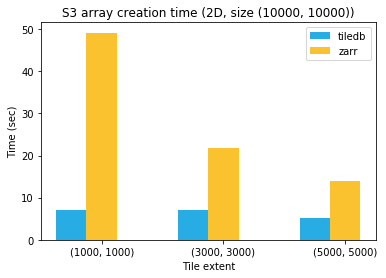

In [7]:
array_creation_times = {'tiledb': [], 'zarr': []}
tile_extents = [(1000, 1000), (3000, 3000), (5000, 5000)]
for t_ext in tile_extents:
    array_creation_times['tiledb'].append(
        min(timeit(lambda: write_2d_tiledb_array(array_data, t_ext), setup=remove_arrays, repeat=3)))
    array_creation_times['zarr'].append(
        min(timeit(lambda: write_2d_zarr_array(array_data, t_ext), setup=remove_arrays, repeat=3)))

print(array_creation_times)

plot_bars(array_creation_times, 'S3 array creation time (2D, size {})'.format(num_array_values),
          'Tile extent', 'Time (sec)')

In all three tile configurations, TileDB write time outperforms Zarr, with the advantage decreasing as the tile size increases. This is due to TileDB's efficient multithreaded S3 layer, which buffers and dispatches many small write operations int a larger, parallel write request.

## Read performance

Next we'll compare performance when reading from the array on S3 using TileDB and Zarr.

To start, we'll issue a read operation of a single cell of the array. Because both TileDB and Zarr are chunked data formats, reading a single cell will require reading the entire chunk of data containing the cell. First we'll define two helper functions to read a specified region ("subarray") from the array using each library.

In [8]:
def read_tiledb_2d_subarray(subarray):
    ctx = tiledb.Ctx(config)
    with tiledb.DenseArray(ctx, tiledb_array_path, mode='r') as A:
        data = A[subarray[0] : subarray[1], subarray[2] : subarray[3]]


def read_zarr_2d_subarray(subarray):
    A = zarr.open(zarr_array_path, mode='r')
    data = A[subarray[0] : subarray[1], subarray[2] : subarray[3]]


To start, we'll issue a read operation of a single cell `(100, 100)` of the array. Because both TileDB and Zarr are chunked data formats, reading a single cell will require reading the entire chunk of data containing the cell. Due to the variability of S3 performance we'll run 10 trials. Then we'll plot the comparison for all three tile configurations.

{'tiledb': [0.23752784729003906, 0.3549535274505615, 0.4742014408111572], 'zarr': [0.14882302284240723, 0.7292537689208984, 1.9040195941925049]}


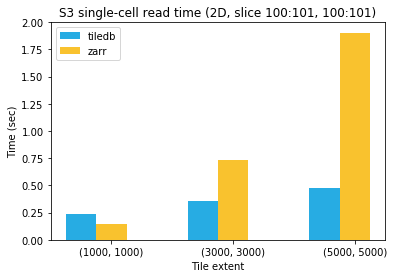

In [9]:
single_cell_read_times = {'tiledb': [], 'zarr': []}
subarray = (100, 101, 100, 101)
for t_ext in tile_extents:
    remove_arrays()
    write_2d_tiledb_array(array_data, t_ext)
    write_2d_zarr_array(array_data, t_ext)
    single_cell_read_times['tiledb'].append(min(timeit(lambda: read_tiledb_2d_subarray(subarray), repeat=10)))
    single_cell_read_times['zarr'].append(min(timeit(lambda: read_zarr_2d_subarray(subarray), repeat=10)))

print(single_cell_read_times)

plot_bars(single_cell_read_times, 'S3 single-cell read time (2D, slice {}:{}, {}:{})'.format(*subarray), 
          'Tile extent', 'Time (sec)')

Conversely to write performance, TileDB's read performance advantage over Zarr increases as the tile size increases, again due to TileDB's efficient I/O layer which dispatches large reads as several smaller parallel read requests, increasing throughput.

Next we'll issue read operations of a large slice of array data. We'll specify a subarray large enough to intersect all 4 of the largest tile size, and plot the comparison for all three tile configurations.

{'tiledb': [0.5400974750518799, 0.8413023948669434, 0.9746074676513672], 'zarr': [3.395373582839966, 6.2517945766448975, 7.503728151321411]}


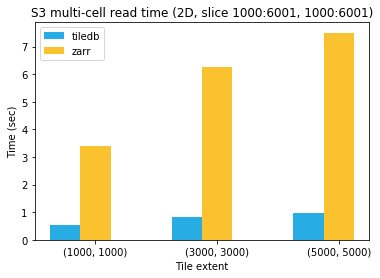

In [10]:
subarray_read_times = {'tiledb': [], 'zarr': []}
subarray = (1000, 6001, 1000, 6001)
for t_ext in tile_extents:
    remove_arrays()
    write_2d_tiledb_array(array_data, t_ext)
    write_2d_zarr_array(array_data, t_ext)
    subarray_read_times['tiledb'].append(min(timeit(lambda: read_tiledb_2d_subarray(subarray), repeat=5)))
    subarray_read_times['zarr'].append(min(timeit(lambda: read_zarr_2d_subarray(subarray), repeat=5)))

print(subarray_read_times)

plot_bars(subarray_read_times, 'S3 multi-cell read time (2D, slice {}:{}, {}:{})'.format(*subarray), 
          'Tile extent', 'Time (sec)')


Again due to TileDB's efficient parallel I/O layer, TileDB's advantage over Zarr is greater in this case.

# Performance on local disk

First, we'll modify the TileDB and Zarr paths to point to a local paths rooted at a directory on the SSD. We'll also configure TileDB to use a single-threaded configuration, to avoid excessive disk contention by multiple parallel I/O operations. We chose to run the local experiments on a local SSD due to the performance variability of EBS we observed.

We also define a helper function to drop the OS local filesystem caches, which will help reduce the effect of filesystem caching on the read performance.

We'll then simply repeat the same experiments as with S3, but now measuring the time when the array data resides on a local disk.

In [11]:
array_root_dir = '/ssd'
tiledb_array_path = os.path.join(array_root_dir, tiledb_array_name)
zarr_array_path = os.path.join(array_root_dir, zarr_array_name)

config = tiledb.Config()
config['sm.num_tbb_threads'] = 1
config['vfs.num_threads'] = 1


def drop_fs_cache():
    "Drops the OS filesystem cache(s)."
    # On macOS: subprocess.call(['sudo', 'purge'])
    subprocess.call(['sudo', 'sh', '-c', 'echo 3 >/proc/sys/vm/drop_caches'])
    
    
def remove_arrays():
    "Remove any persisted arrays."
    for array in [tiledb_array_path, zarr_array_path]:
        if os.path.exists(array):
            shutil.rmtree(array)

## Array write

Below are the times for writing the array on the local SSD. 

{'tiledb': [2.332366943359375, 2.8944451808929443, 2.6814193725585938], 'zarr': [2.09130859375, 2.2498204708099365, 2.36016845703125]}


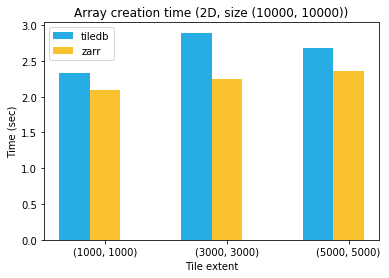

In [12]:
array_creation_times = {'tiledb': [], 'zarr': []}
tile_extents = [(1000, 1000), (3000, 3000), (5000, 5000)]
for t_ext in tile_extents:
    array_creation_times['tiledb'].append(
        min(timeit(lambda: write_2d_tiledb_array(array_data, t_ext), setup=remove_arrays, repeat=3)))
    array_creation_times['zarr'].append(
        min(timeit(lambda: write_2d_zarr_array(array_data, t_ext), setup=remove_arrays, repeat=3)))

print(array_creation_times)

plot_bars(array_creation_times, 'Array creation time (2D, size {})'.format(num_array_values),
          'Tile extent', 'Time (sec)')

Zarr has the performance edge in this case, slightly outperforming TileDB's local array writes. Due to a known issue in the currently released version of TileDB, reducing the number of TileDB threads (to reduce disk contention) also reduces the number of threads available for parallel compression. When this issue is fixed with the next TileDB release we expect to match Zarr's performance.

## Read performance

Next we'll repeat the single-cell and subarray reads, now reading from the array on local disk. Note that we add a call to drop the FS caches, which will occur before each read operation.

{'tiledb': [0.014350652694702148, 0.06535172462463379, 0.20049643516540527], 'zarr': [0.008392333984375, 0.05129098892211914, 0.14158105850219727]}


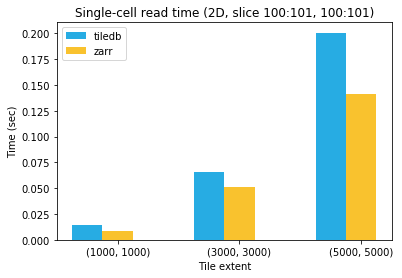

{'tiledb': [0.5103681087493896, 0.8029735088348389, 0.9591667652130127], 'zarr': [0.26305365562438965, 0.6103935241699219, 0.7224917411804199]}


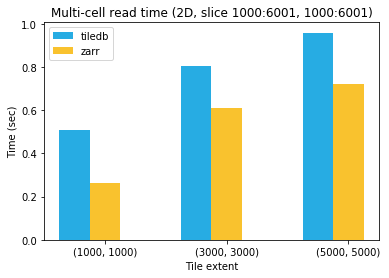

In [13]:
single_cell_read_times = {'tiledb': [], 'zarr': []}
subarray = (100, 101, 100, 101)
for t_ext in tile_extents:
    remove_arrays()
    write_2d_tiledb_array(array_data, t_ext)
    write_2d_zarr_array(array_data, t_ext)
    single_cell_read_times['tiledb'].append(min(timeit(lambda: read_tiledb_2d_subarray(subarray), setup=drop_fs_cache, repeat=5)))
    single_cell_read_times['zarr'].append(min(timeit(lambda: read_zarr_2d_subarray(subarray), setup=drop_fs_cache, repeat=5)))

print(single_cell_read_times)

plot_bars(single_cell_read_times, 'Single-cell read time (2D, slice {}:{}, {}:{})'.format(*subarray), 
          'Tile extent', 'Time (sec)')

subarray_read_times = {'tiledb': [], 'zarr': []}
subarray = (1000, 6001, 1000, 6001)
for t_ext in tile_extents:
    remove_arrays()
    write_2d_tiledb_array(array_data, t_ext)
    write_2d_zarr_array(array_data, t_ext)
    subarray_read_times['tiledb'].append(min(timeit(lambda: read_tiledb_2d_subarray(subarray), setup=drop_fs_cache, repeat=5)))
    subarray_read_times['zarr'].append(min(timeit(lambda: read_zarr_2d_subarray(subarray), setup=drop_fs_cache, repeat=5)))

print(subarray_read_times)

plot_bars(subarray_read_times, 'Multi-cell read time (2D, slice {}:{}, {}:{})'.format(*subarray), 
          'Tile extent', 'Time (sec)')

Again Zarr outperforms TileDB by a small amount. We believe this is due to the threading issue mentioned above, and also a Zarr optimization not yet implemented in TileDB. Zarr only decompresses sub-chunks that intersect the read region, whereas TileDB decompresses the entire tile, even though compressed chunks within that tile may not be needed to satisfy the read query. We plan to implement this optimization in the next version of TileDB.

In [14]:
num_array_values = 100000000
array_data = np.random.rand(num_array_values)
print('Array data is {:.2f} MB uncompressed.'.format(array_data.nbytes / (1024 * 1024.0)))

Array data is 762.94 MB uncompressed.


We'll define some new helper functions to create persistent 1D arrays with a given tile or chunk size, and to remove all three arrays.

In [15]:
bcolz_array_name = 'bcolz_array'
bcolz_array_path = os.path.join(array_root_dir, bcolz_array_name)

def write_1d_tiledb_array(array_data, tile_extent):
    ctx = tiledb.Ctx(config)
    dom = tiledb.Domain(ctx, tiledb.Dim(ctx, domain=(0, num_array_values - 1),
                                        tile=tile_extent, dtype=np.uint32))
    schema = tiledb.ArraySchema(ctx, domain=dom, sparse=False,
                                attrs=[tiledb.Attr(ctx, name='a', 
                                                   dtype=np.float64, compressor=tiledb_compressor)])
    tiledb.DenseArray.create(tiledb_array_path, schema)
    with tiledb.DenseArray(ctx, tiledb_array_path, mode='w') as A:
        A[:] = array_data
    sync_fs()


def write_1d_bcolz_array(array_data, tile_extent):
    A = bcolz.carray(array_data, rootdir=bcolz_array_path, mode='w', chunklen=tile_extent)
    A.flush()
    sync_fs()


def write_1d_zarr_array(array_data, tile_extent):
    A = zarr.open(zarr_array_path, mode='w', compressor=zarr_compressor, 
                  shape=array_data.shape, chunks=(tile_extent,), dtype=np.float64)
    A[:] = array_data
    sync_fs()
    

def remove_arrays():
    "Remove any persisted arrays."
    for array in [tiledb_array_path, bcolz_array_path, zarr_array_path]:
        if os.path.exists(array):
            shutil.rmtree(array)

Next we'll persist the array data separately using each library and plot the minimum time over 3 iterations.

{'bcolz': [1.975130558013916, 1.944108009338379, 2.0615646839141846], 'tiledb': [2.313807725906372, 2.349884510040283, 2.505099296569824], 'zarr': [2.1311731338500977, 1.9453234672546387, 1.9535973072052002]}


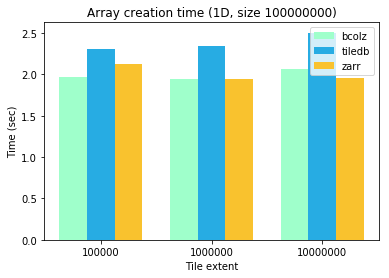

In [16]:
array_creation_times = {'tiledb': [], 'zarr': [], 'bcolz': []}
tile_extents = [100000, 1000000, 10000000]
for t_ext in tile_extents:
    array_creation_times['tiledb'].append(
        min(timeit(lambda: write_1d_tiledb_array(array_data, t_ext), setup=remove_arrays, repeat=3)))
    array_creation_times['zarr'].append(
        min(timeit(lambda: write_1d_zarr_array(array_data, t_ext), setup=remove_arrays, repeat=3)))
    array_creation_times['bcolz'].append(
        min(timeit(lambda: write_1d_bcolz_array(array_data, t_ext), setup=remove_arrays, repeat=3)))

print(array_creation_times)

plot_bars(array_creation_times, 'Array creation time (1D, size {})'.format(num_array_values),
          'Tile extent', 'Time (sec)')


For the 1 dimensional case, bcolz mirrors the write performance of zarr, with TileDB trailing slightly behind for the same reasons mentioned earlier.

## Read performance



In [17]:
def read_tiledb_1d_subarray(subarray):
    ctx = tiledb.Ctx(config)
    with tiledb.DenseArray(ctx, tiledb_array_path, mode='r') as A:
        data = A[subarray[0] : subarray[1]]


def read_bcolz_1d_subarray(subarray):
    with bcolz.carray(rootdir=bcolz_array_path, mode='r') as A:
        data = A[subarray[0] : subarray[1]]


def read_zarr_1d_subarray(subarray):
    A = zarr.open(zarr_array_path, mode='r')
    data = A[subarray[0] : subarray[1]]

Next we'll time and plot the results over 10 iterations.

{'bcolz': [0.0025892257690429688, 0.009031057357788086, 0.06132078170776367], 'tiledb': [0.003698587417602539, 0.01388239860534668, 0.07156515121459961], 'zarr': [0.002671480178833008, 0.008879661560058594, 0.05358529090881348]}


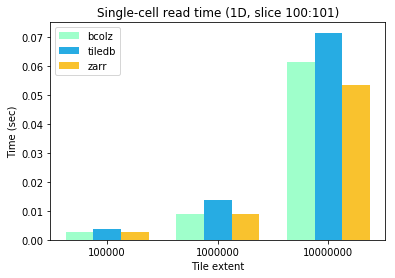

In [18]:
single_cell_read_times = {'tiledb': [], 'zarr': [], 'bcolz': []}
subarray = (100, 101)
for t_ext in tile_extents:
    remove_arrays()
    write_1d_tiledb_array(array_data, t_ext)
    write_1d_bcolz_array(array_data, t_ext)
    write_1d_zarr_array(array_data, t_ext)
    single_cell_read_times['tiledb'].append(min(timeit(lambda: read_tiledb_1d_subarray(subarray), setup=drop_fs_cache, repeat=5)))
    single_cell_read_times['bcolz'].append(min(timeit(lambda: read_bcolz_1d_subarray(subarray), setup=drop_fs_cache, repeat=5)))
    single_cell_read_times['zarr'].append(min(timeit(lambda: read_zarr_1d_subarray(subarray), setup=drop_fs_cache, repeat=5)))

print(single_cell_read_times)

plot_bars(single_cell_read_times, 'Single-cell read time (1D, slice {}:{})'.format(*subarray), 
          'Tile extent', 'Time (sec)')

Due to the underlying similarities of zarr and bcolz for the 1-dimensional case, we see (unsurprisingly) that their performance is closely matched. TileDB's performance is similar to the 2-dimensional case, trailing slightly behind.

We'll now read a large slice of the 1D array, crossing all of the tiles of the largest size.

{'bcolz': [0.1575298309326172, 0.07318973541259766, 0.1619887351989746], 'tiledb': [0.11631631851196289, 0.139085054397583, 0.19818735122680664], 'zarr': [0.09921121597290039, 0.06763005256652832, 0.14014267921447754]}


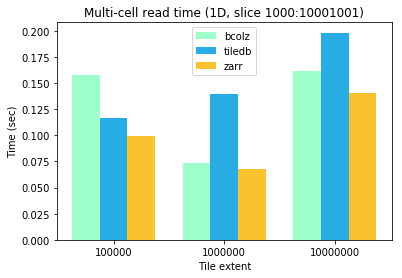

In [19]:
subarray_read_times = {'tiledb': [], 'zarr': [], 'bcolz': []}
subarray = (1000, 1000 + tile_extents[-1] + 1)
for t_ext in tile_extents:
    remove_arrays()
    write_1d_tiledb_array(array_data, t_ext)
    write_1d_bcolz_array(array_data, t_ext)
    write_1d_zarr_array(array_data, t_ext)
    subarray_read_times['tiledb'].append(min(timeit(lambda: read_tiledb_1d_subarray(subarray), setup=drop_fs_cache, repeat=5)))
    subarray_read_times['bcolz'].append(min(timeit(lambda: read_bcolz_1d_subarray(subarray), setup=drop_fs_cache, repeat=5)))
    subarray_read_times['zarr'].append(min(timeit(lambda: read_zarr_1d_subarray(subarray), setup=drop_fs_cache, repeat=5)))

print(subarray_read_times)

plot_bars(subarray_read_times, 'Multi-cell read time (1D, slice {}:{})'.format(*subarray),
          'Tile extent', 'Time (sec)')


We can see that the read performance trends in this case are very similar to the single-cell case.

# Conclusion

TileDB's persistent array format is designed around streaming tiles to storage in contiguous batched writes.  This reduces the number of file descriptors (or S3 objects) that are created upon writing to disk / bucket.  Additionally, TileDB uses a multithreaded virtual file system (VFS) backend to abstract local / S3  operations and deliver parallel writes / reads.  These two aspects of TileDB's design allow for improved performance on object store backends compared to other chunked storage managers such as Zarr and Bcolz.   

For small to medium sized local writes / reads, Zarr and Bcolz have an advantage because the multithreaded VFS layer in TileDB introduces unnecessary overhead and we can see improved performance when limiting the number of threads TileDB uses by setting appropriate configuration parameters.  We have identified the cause of this issue and are working on improving local `file://` backend performance in the next TileDB release.  

TileDB has benefited greatly from studying and learning from the design choices of Blosc / Bcolz, and Zarr.  We plan on incorporating more of the ideas from these Python libraries in the future and making their benefits available to other languages such as R, Java, etc. and on multiple cloud / object store backends.